In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,date
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
data = pd.read_csv('dataset/data.csv', encoding='ISO-8859-1', delimiter=',')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## limpeza e tratamento dos dados

###### Verificando missings em cada coluna

In [23]:
data.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

###### Removendo os registros que não tem CustomerId

In [4]:
data = data.dropna(subset=['CustomerID'])

In [25]:
data.shape

(406829, 8)

In [26]:
data.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

###### Coluna de Quantidade com valores negativos (minimo com discrepância)

In [27]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


###### Removendo os itens com quantidade negativa

In [5]:
data = data[data.Quantity > 0]

In [29]:
data.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


## Analise exploratória

###### Adicionando a colunas

In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [7]:
data['InvoiceDate'].describe()

<ipython-input-7-b45d2d7a7dfa>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['InvoiceDate'].describe()


count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [8]:
data['invoice_month_name'] = data['InvoiceDate'].dt.month_name()

In [9]:
data['invoice_month'] = data['InvoiceDate'].dt.month

In [10]:
data['invoice_year'] = data['InvoiceDate'].dt.year

In [11]:
data['revenue'] = data['Quantity'] * data['UnitPrice']

In [12]:
data['hour'] = pd.to_datetime(data['InvoiceDate']).dt.hour

In [13]:
data['invoice_year/invoice_month'] = data['invoice_year'].astype(str)  + '/' + pd.to_datetime(data['InvoiceDate']).dt.month.astype(str)

In [14]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_month_name,invoice_month,invoice_year,revenue,hour,invoice_year/invoice_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,December,12,2010,15.30,8,2010/12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,12,2010,20.34,8,2010/12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,December,12,2010,22.00,8,2010/12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,12,2010,20.34,8,2010/12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,December,12,2010,20.34,8,2010/12


###### Visualizando o somatório anual de vendas

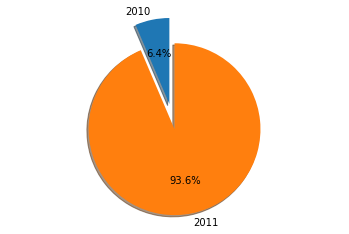

,invoice_year,revenue
0,2010,5.727139e+05
1,2011,8.338694e+06


In [26]:
orders_year = data.groupby(by=['invoice_year'], as_index=False)['revenue'].sum()
explode = (0.3, 0)
fig1, ax1 = plt.subplots()
ax1.pie(orders_year.revenue, labels=orders_year.invoice_year.astype(str), explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

data.groupby(by=['invoice_year'], as_index=False)['revenue'].sum()

###### Visualizando o somatório mensal de vendas

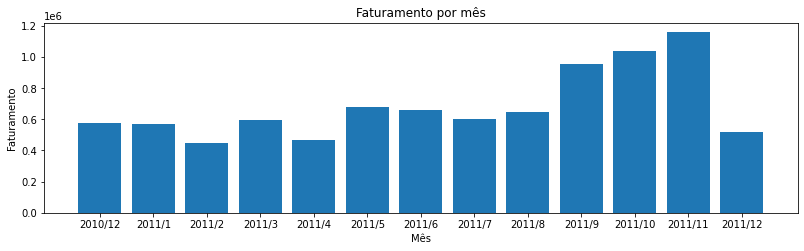

In [74]:
orders_month_year = data.groupby(by=['invoice_year', 'invoice_month'], as_index=False)['revenue'].sum()
orders_month_year['month_year'] = orders_month_year['invoice_year'].astype(str) + '/' + orders_month_year['invoice_month'].astype(str)
plt.title('Faturamento por mês')
plt.xlabel('Mês')
plt.ylabel('Faturamento')
plt.bar(orders_month_year.month_year, orders_month_year.revenue)

fig = plt.gcf()
fig.set_size_inches(13.5, 3.5)

###### Quantidade de vendas por país

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

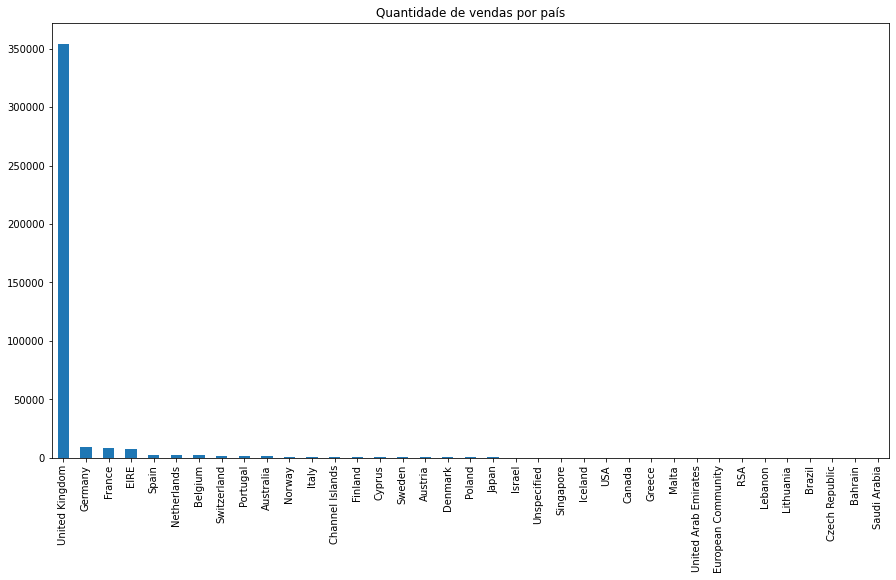

In [78]:
data['Country'].value_counts().plot(kind='bar', title='Quantidade de vendas por país', figsize=[15, 8])
data['Country'].value_counts()

###### Quantidade de vendas pela hora do dia

<AxesSubplot:title={'center':'Quantidade de vendas pela hora do dia'}>

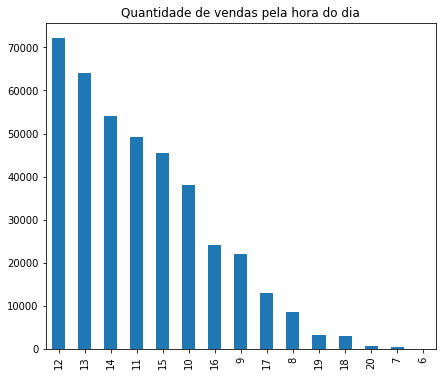

In [81]:
data['hour'].value_counts().plot(kind='bar', title='Quantidade de vendas pela hora do dia', figsize=[7, 6])

###### Gráfico de dispersão [relação mês e quantidade]

<AxesSubplot:xlabel='Quantity', ylabel='revenue'>

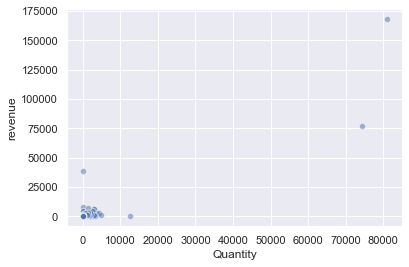

In [37]:
sns.set()
sns.scatterplot(x="Quantity", y="revenue", sizes=(40, 400), alpha=.5, palette="muted", data=data)

<AxesSubplot:xlabel='revenue'>

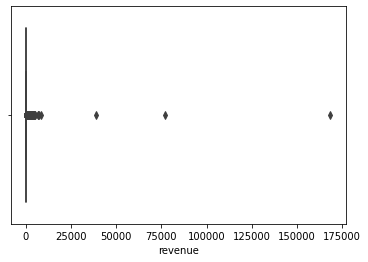

In [27]:
sns.boxplot(x=data["revenue"])

{'whiskers': [<matplotlib.lines.Line2D at 0x2e1721ff970>,
 'caps': [<matplotlib.lines.Line2D at 0x2e17106b070>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e1721ff610>],
 'medians': [<matplotlib.lines.Line2D at 0x2e17106b730>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e17106ba90>],
 'means': []}

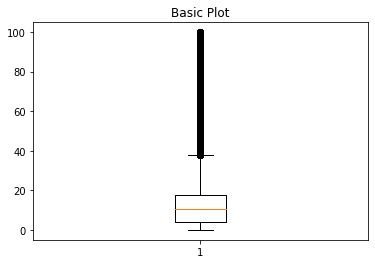

In [35]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data['revenue'][data['revenue'] < 100])

<AxesSubplot:>

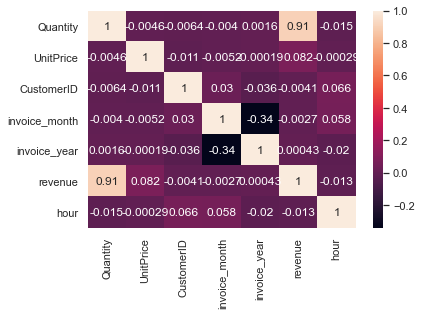

In [38]:
sns.heatmap(data.corr(), annot = True)

### Separação das bases para predição do proximo dia de compra

Teremos dois dataframes, o dataframe histórico contendo as vendas anteriores a 01/09/2011 e o dataframe que representa o futuro, contendo as vendas posteriores a 01/09/2011

In [58]:
data_hist = data[(data.InvoiceDate < datetime(2011,9,1))].reset_index(drop=True)
data_next = data[(data.InvoiceDate >= datetime(2011,9,1))].reset_index(drop=True)

In [59]:
data_hist['InvoiceDate'].describe()

count                  226488
unique                  10767
top       2011-05-22 13:01:00
freq                      299
first     2010-12-01 08:26:00
last      2011-08-31 17:16:00
Name: InvoiceDate, dtype: object

In [60]:
data_next['InvoiceDate'].describe()

count                  171436
unique                   6519
top       2011-11-14 15:27:00
freq                      542
first     2011-09-01 08:25:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [61]:
data_clientes = pd.DataFrame(data_hist['CustomerID'].unique())
data_clientes.columns = ['CustomerID']

In [62]:
data_clientes.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
